In [246]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


import psycopg2
from sqlalchemy import create_engine, text
from sqlalchemy.types import String, Numeric, Integer, Float, Date, DateTime

In [247]:
df_cust = pd.read_csv("raw_data/customer_data.csv")
df_fx = pd.read_csv("raw_data/fx_gbp.csv", encoding='ISO-8859-1', skiprows=3)
df_trans = pd.read_csv("raw_data/transaction_data.csv")

#### Load and Inspect Data

In [248]:
df_cust.head()

,buyer_id,gender,membership_length,age_group
0,505,F,0.2,50-60
1,1989,F,0.8,60+
2,2234,F,0.4,50-60
3,2619,F,0.4,50-60
4,3392,F,2.3,50-60


In [249]:
df_fx.head()

,currency,rate,Unnamed: 2
0,THB,37.386304,NaN
1,BIF,2242.924895,NaN
2,NGN,439.534518,NaN
3,LKR,214.801634,NaN
4,CHF,1.194301,NaN


In [250]:
df_trans.head()

,purchase_id,buyer_id,country,product_id,department,category,purchase_date,currency,value_of_item
0,3,10258663,AU,113961581,Accessories,Accessories,02/08/2019,AUD,15.0
1,6,9135670,AU,114780505,Accessories,Accessories,02/08/2019,AUD,33.5
2,9,10869093,AU,115216176,Accessories,Accessories,07/08/2019,AUD,65.0
3,27,10182131,AU,112217251,Accessories,Accessories,02/08/2019,AUD,40.0
4,31,5766224,AU,107519551,Accessories,Accessories,02/08/2019,AUD,25.0


In [251]:
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129113 entries, 0 to 129112
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   buyer_id           129113 non-null  int64  
 1   gender             129113 non-null  object 
 2   membership_length  129113 non-null  float64
 3   age_group          129113 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.9+ MB


In [252]:
df_cust['buyer_id'] = df_cust['buyer_id'].astype('str')

In [253]:
df_fx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   currency    168 non-null    object 
 1   rate        168 non-null    float64
 2   Unnamed: 2  0 non-null      float64
dtypes: float64(2), object(1)
memory usage: 27.7+ KB


In [254]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217977 entries, 0 to 217976
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   purchase_id    217977 non-null  int64  
 1   buyer_id       217977 non-null  int64  
 2   country        217977 non-null  object 
 3   product_id     217977 non-null  int64  
 4   department     217977 non-null  object 
 5   category       217977 non-null  object 
 6   purchase_date  217977 non-null  object 
 7   currency       217977 non-null  object 
 8   value_of_item  217977 non-null  float64
dtypes: float64(1), int64(3), object(5)
memory usage: 15.0+ MB


In [255]:
df_trans['purchase_id'] = df_trans['purchase_id'].astype('str')
df_trans['buyer_id'] = df_trans['buyer_id'].astype('str')
df_trans['product_id'] = df_trans['product_id'].astype('str')
df_trans['purchase_date'] = pd.to_datetime(df_trans['purchase_date'], format='%d/%m/%Y')


In [256]:
df_fx = df_fx.drop(columns=['Unnamed: 2'])
df_fx =df_fx.dropna()

In [257]:
df_fx['rate'] = round(df_fx['rate'],2)

In [258]:
df_fx

,currency,rate
0,THB,37.39
1,BIF,2242.92
2,NGN,439.53
3,LKR,214.80
4,CHF,1.19
...,...,...
163,KWD,0.37
164,SEK,11.70
165,GGP,1.00
166,EUR,1.09


In [259]:
merged_data = pd.merge(df_trans, df_cust, on='buyer_id', how='left')

In [260]:

rows_with_nan = merged_data[merged_data.isna().any(axis=1)]
rows_with_nan

,purchase_id,buyer_id,country,product_id,department,category,purchase_date,currency,value_of_item,gender,membership_length,age_group
864,10679,9423587,FR,111706043,Accessories,Accessories,2019-08-04,EUR,95.00,NaN,NaN,NaN
1034,12367,1603781,FR,113495310,Accessories,Accessories,2019-08-04,EUR,32.00,NaN,NaN,NaN
1040,12403,15125005,FR,115030842,Accessories,Accessories,2019-08-04,EUR,40.00,NaN,NaN,NaN
1042,12415,5773507,FR,114064965,Accessories,Accessories,2019-08-01,EUR,63.00,NaN,NaN,NaN
1209,13994,15303845,FR,100363761,Accessories,Accessories,2019-08-04,EUR,65.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
206316,185596,4311831,FR,111517603,Womens apparel,Tops - Womens,2019-08-04,USD,60.00,NaN,NaN,NaN
206534,186462,1328339,FR,88607245,Womens apparel,Tops - Womens,2019-08-03,USD,18.00,NaN,NaN,NaN
210256,203656,6048591,FR,115164737,Womens apparel,Tops - Womens,2019-08-04,USD,110.50,NaN,NaN,NaN
212007,211499,13049663,FR,93084272,Womens apparel,Tops - Womens,2019-08-01,USD,44.00,NaN,NaN,NaN


In [261]:
merged_data = merged_data.dropna()

In [262]:
duplicate_count = merged_data.duplicated().sum()
print(f"Number of duplicated rows: {duplicate_count}")

Number of duplicated rows: 0


In [263]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217757 entries, 0 to 217976
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   purchase_id        217757 non-null  object        
 1   buyer_id           217757 non-null  object        
 2   country            217757 non-null  object        
 3   product_id         217757 non-null  object        
 4   department         217757 non-null  object        
 5   category           217757 non-null  object        
 6   purchase_date      217757 non-null  datetime64[ns]
 7   currency           217757 non-null  object        
 8   value_of_item      217757 non-null  float64       
 9   gender             217757 non-null  object        
 10  membership_length  217757 non-null  float64       
 11  age_group          217757 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(9)
memory usage: 21.6+ MB


In [264]:

fx_dict = df_fx.set_index('currency')['rate'].to_dict()

In [265]:
fx_dict

{'THB': 37.39,
 'BIF': 2242.92,
 'NGN': 439.53,
 'LKR': 214.8,
 'CHF': 1.19,
 'XAG': 0.07,
 'AFN': 95.13,
 'HRK': 8.02,
 'NPR': 134.55,
 'PKR': 193.33,
 'SYP': 626.68,
 'GHS': 6.6,
 'MUR': 43.77,
 'XOF': 717.99,
 'TZS': 2795.5,
 'CNY': 8.36,
 'MKD': 67.34,
 'QAR': 4.43,
 'RUB': 79.37,
 'SAR': 4.55,
 'ETB': 35.34,
 'KRW': 1472.02,
 'FKP': 1.0,
 'JEP': 1.0,
 'SGD': 1.67,
 'EGP': 20.1,
 'OMR': 0.47,
 'STD': 26212.61,
 'FJD': 2.65,
 'IMP': 1.0,
 'VUV': 141.29,
 'KHR': 4975.47,
 'BAM': 2.12,
 'BOB': 8.39,
 'YER': 303.51,
 'LTL': 3.59,
 'LRD': 246.66,
 'AMD': 578.65,
 'CAD': 1.6,
 'BYN': 2.48,
 'IDR': 17330.57,
 'MNT': 3228.83,
 'DKK': 8.17,
 'TJS': 11.43,
 'ZMW': 15.79,
 'CVE': 120.29,
 'SDG': 54.9,
 'USD': 1.22,
 'ANG': 2.17,
 'BZD': 2.45,
 'GBP': 1.0,
 'HNL': 29.95,
 'XCD': 3.28,
 'UYU': 41.74,
 'ERN': 18.25,
 'GTQ': 9.32,
 'LBP': 1834.42,
 'TTD': 8.21,
 'DZD': 145.95,
 'MRO': 433.46,
 'HTG': 115.16,
 'LSL': 17.23,
 'RON': 5.14,
 'SRD': 9.06,
 'XAU': 0.0,
 'BDT': 102.73,
 'AWG': 2.19,
 'T

In [266]:

def convert_to_gbp(row):
    return round (row['value_of_item'] / fx_dict.get(row['currency'], 1), 2)  # Default to 1 if currency not found

In [267]:

merged_data['value_in_gbp'] = merged_data.apply(convert_to_gbp, axis=1)

In [268]:
print("MIN:", merged_data['purchase_date'].min(),
"MAX:", merged_data['purchase_date'].max())

MIN: 2019-08-01 00:00:00 MAX: 2019-08-07 00:00:00


In [269]:
merged_data['purchase_date'].unique()

array(['2019-08-02T00:00:00.000000000', '2019-08-07T00:00:00.000000000',
       '2019-08-03T00:00:00.000000000', '2019-08-01T00:00:00.000000000',
       '2019-08-06T00:00:00.000000000', '2019-08-04T00:00:00.000000000',
       '2019-08-05T00:00:00.000000000'], dtype='datetime64[ns]')

In [270]:

merged_data['day_of_week'] = merged_data['purchase_date'].dt.day_name()
merged_data.head()

,purchase_id,buyer_id,country,product_id,department,category,purchase_date,currency,value_of_item,gender,membership_length,age_group,value_in_gbp,day_of_week
0,3,10258663,AU,113961581,Accessories,Accessories,2019-08-02,AUD,15.0,F,0.1,30-40,8.33,Friday
1,6,9135670,AU,114780505,Accessories,Accessories,2019-08-02,AUD,33.5,F,0.2,50-60,18.61,Friday
2,9,10869093,AU,115216176,Accessories,Accessories,2019-08-07,AUD,65.0,F,0.4,30-40,36.11,Wednesday
3,27,10182131,AU,112217251,Accessories,Accessories,2019-08-02,AUD,40.0,F,0.2,50-60,22.22,Friday
4,31,5766224,AU,107519551,Accessories,Accessories,2019-08-02,AUD,25.0,F,0.2,40-50,13.89,Friday


In [271]:
merged_data['day_of_week'].unique()

array(['Friday', 'Wednesday', 'Saturday', 'Thursday', 'Tuesday', 'Sunday',
       'Monday'], dtype=object)

In [272]:
df_cust.to_csv('clean_data/cleaned_cust.csv', index=False)
df_fx.to_csv('clean_data/clean_fx.csv', index=False)
df_trans.to_csv('clean_data/clean_transaction_cust.csv', index=False)
merged_data.to_csv('clean_data/merged.csv', index=False)

### Sending data to SQL

In [224]:

db_params = {
    'host': 'localhost',
    'database': 'aymanahmed',
    'user': 'aymanahmed',
    'password': 'admin'
}

In [225]:

engine = create_engine(f'postgresql://{db_params["user"]}:{db_params["password"]}@{db_params["host"]}/{db_params["database"]}')

df_cust = pd.DataFrame(df_cust)  
df_fx = pd.DataFrame(df_fx)  
df_trans = pd.DataFrame(df_trans)  

dataframes = {
    'cust': df_cust,
    'fx': df_fx,
    'trans': df_trans,
    'merged': merged_data
}

# Define your schema name
schema_name = 'RAPP'

for table_name, df in dataframes.items():
    print(f"Contents of '{table_name}' DataFrame:")
    print(df.head(2))  
    print("\n")
    df.to_sql(table_name, engine, if_exists='replace', index=False)
#df.to_sql(table_name, engine, if_exists='replace', index=False, schema=schema_name)

Contents of 'cust' DataFrame:
  buyer_id gender  membership_length age_group
0      505      F                0.2     50-60
1     1989      F                0.8       60+


Contents of 'fx' DataFrame:
  currency     rate
0      THB    37.39
1      BIF  2242.92


Contents of 'trans' DataFrame:
  purchase_id  buyer_id country product_id   department     category  \
0           3  10258663      AU  113961581  Accessories  Accessories   
1           6   9135670      AU  114780505  Accessories  Accessories   

  purchase_date currency  value_of_item  
0    2019-08-02      AUD           15.0  
1    2019-08-02      AUD           33.5  


Contents of 'merged' DataFrame:
  purchase_id  buyer_id country product_id   department     category  \
0           3  10258663      AU  113961581  Accessories  Accessories   
1           6   9135670      AU  114780505  Accessories  Accessories   

  purchase_date currency  value_of_item gender  membership_length age_group  \
0    2019-08-02      AUD         

In [30]:
sales_by_day = merged_data.groupby('purchase_date')['value_in_gbp'].sum()

In [31]:
sales_by_day = pd.DataFrame(sales_by_day)

In [32]:
sales_by_day_df = sales_by_day.reset_index()
sales_by_day_df['day_of_week'] = sales_by_day_df['purchase_date'].dt.day_name()

sales_by_day_df.set_index('purchase_date', inplace=True)

print(sales_by_day_df)

                value_in_gbp day_of_week
purchase_date                           
2019-08-01     775745.649146    Thursday
2019-08-02     729377.050326      Friday
2019-08-03     600015.545082    Saturday
2019-08-04     668900.121405      Sunday
2019-08-05     754439.087726      Monday
2019-08-06     764055.003733     Tuesday
2019-08-07     732095.862581   Wednesday


In [33]:
sales_by_day

,value_in_gbp
purchase_date,
2019-08-01,775745.649146
2019-08-02,729377.050326
2019-08-03,600015.545082
2019-08-04,668900.121405
2019-08-05,754439.087726
2019-08-06,764055.003733
2019-08-07,732095.862581


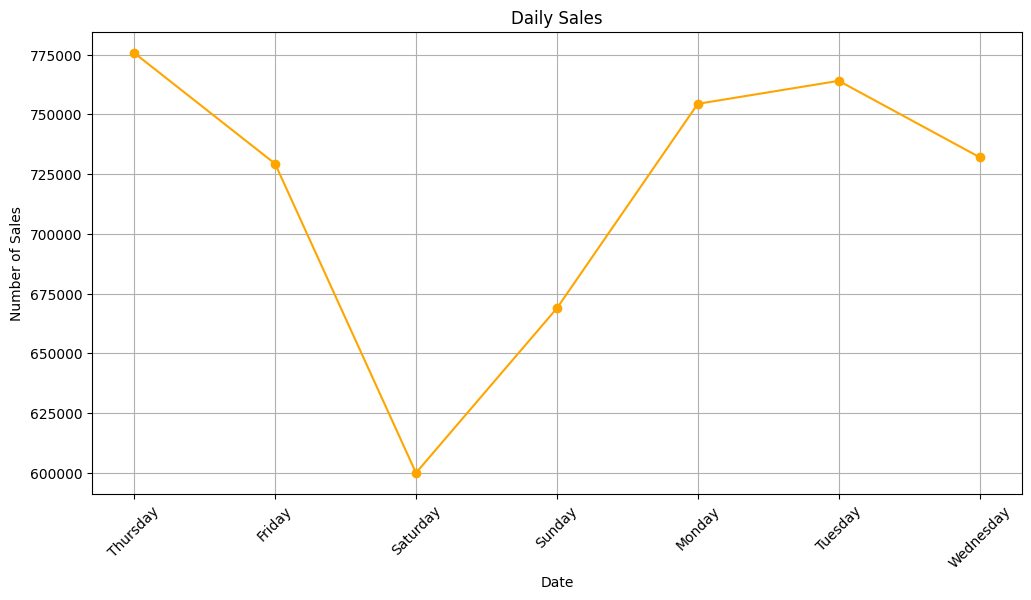

In [34]:
# Plot daily sales with day of the week as labels
plt.figure(figsize=(12, 6))
plt.plot(sales_by_day_df.index, sales_by_day_df['value_in_gbp'], marker='o', color='orange')
plt.title('Daily Sales')
plt.xlabel('Date')
plt.ylabel('Number of Sales')
plt.xticks(ticks=sales_by_day_df.index, labels=sales_by_day_df['day_of_week'], rotation=45)
plt.grid(True)
plt.show()

In [78]:
# Example: Descriptive statistics for transaction values
print(merged_data['value_in_gbp'].describe())

count    217757.000000
mean         23.074474
std          31.670370
min           0.010000
25%          10.000000
50%          15.370000
75%          25.000000
max        1876.150000
Name: value_in_gbp, dtype: float64


In [118]:
len(merged_data['product_id'].unique())

207459

In [193]:
df = merged_data[merged_data['buyer_id'].duplicated(keep=False)]

df['Grouped'] = df.groupby('buyer_id')['product_id'].transform(lambda x: ','.join(x))

df = df[['buyer_id','Grouped']].drop_duplicates()

df

/var/folders/n5/2bpmbymn69b77rkgn40q7dph0000gn/T/ipykernel_97389/2786927381.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Grouped'] = df.groupby('buyer_id')['product_id'].transform(lambda x: ','.join(x))


,buyer_id,Grouped
0,10258663,"113961581,113858775"
1,9135670,"114780505,113937823"
6,13711045,"112109399,113721287,58217756,115119706"
7,9670101,"113945269,114130884,105250113"
10,6150332,"114885902,114883384,115123351,114245074,115233254"
...,...,...
216877,4570641,"114749019,114749865"
216923,14463745,"107120434,114744345"
217106,2767595,"115484305,115302996"
217292,7994687,"114617070,110114131"


In [188]:
from itertools import combinations
from collections import Counter

count = Counter()

for row in df['Grouped']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))

for key, value in count.most_common(10):
    print(key, value)

('115430089', '115430089') 1225
('114817926', '114891141') 1188
('114891141', '114891141') 946
('114817926', '114817926') 879
('115317239', '115317461') 550
('115317239', '115317239') 300
('115317461', '115317461') 231
('113888047', '113888047') 171
('115326567', '115326567') 153
('115285403', '115285403') 120


In [189]:
# Assuming `merged_data` has `product_id` and `category` columns
product_category_map = dict(zip(merged_data['product_id'], merged_data['category']))

In [196]:
df = merged_data[merged_data['buyer_id'].duplicated(keep=False)]

df['Grouped'] = df.groupby('buyer_id')['product_id'].transform(lambda x: ','.join(x))

df = df[['buyer_id', 'Grouped']].drop_duplicates()

from itertools import combinations
from collections import Counter

count = Counter()

for row in df['Grouped']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 3)))

# Create a new Counter to include categories
count_with_categories = Counter()

for key, value in count.items():
    # Get the category for each product
    categories = tuple(product_category_map[prod] for prod in key)
    # Update the counter with product pairs and their categories
    count_with_categories.update({(key, categories): value})

for key, value in count_with_categories.most_common(10):
    print(f"Products: {key[0]} (Categories: {key[1]}) - Count: {value}")

df

/var/folders/n5/2bpmbymn69b77rkgn40q7dph0000gn/T/ipykernel_97389/4284093680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Grouped'] = df.groupby('buyer_id')['product_id'].transform(lambda x: ','.join(x))


Products: ('114817926', '114891141', '114891141') (Categories: ('Tops - Mens', 'Tops - Mens', 'Tops - Mens')) - Count: 25542
Products: ('115430089', '115430089', '115430089') (Categories: ('Accessories', 'Accessories', 'Accessories')) - Count: 19600
Products: ('114817926', '114817926', '114891141') (Categories: ('Tops - Mens', 'Tops - Mens', 'Tops - Mens')) - Count: 15444
Products: ('114891141', '114891141', '114891141') (Categories: ('Tops - Mens', 'Tops - Mens', 'Tops - Mens')) - Count: 13244
Products: ('114817926', '114817926', '114817926') (Categories: ('Tops - Mens', 'Tops - Mens', 'Tops - Mens')) - Count: 8381
Products: ('115317239', '115317239', '115317461') (Categories: ('Home', 'Home', 'Home')) - Count: 6600
Products: ('115317239', '115317461', '115317461') (Categories: ('Home', 'Home', 'Home')) - Count: 5775
Products: ('115317239', '115317239', '115317239') (Categories: ('Home', 'Home', 'Home')) - Count: 2300
Products: ('115317461', '115317461', '115317461') (Categories: ('Ho

,buyer_id,Grouped
0,10258663,"113961581,113858775"
1,9135670,"114780505,113937823"
6,13711045,"112109399,113721287,58217756,115119706"
7,9670101,"113945269,114130884,105250113"
10,6150332,"114885902,114883384,115123351,114245074,115233254"
...,...,...
216877,4570641,"114749019,114749865"
216923,14463745,"107120434,114744345"
217106,2767595,"115484305,115302996"
217292,7994687,"114617070,110114131"


In [234]:
grouped_df

,product_id,country,currency,value_of_item,value_in_gbp,cp,sum_value_in_gbp
0,100000133,GB,GBP,13.00,13.00,1,13.00
1,100000592,US,USD,19.75,16.19,1,16.19
2,100001897,GB,GBP,18.00,18.00,1,18.00
3,100001983,GB,GBP,65.00,65.00,1,65.00
4,100002335,GB,GBP,152.50,152.50,1,152.50
...,...,...,...,...,...,...,...
209558,99997638,US,USD,105.00,86.07,1,86.07
209559,99998280,US,USD,10.00,8.20,2,16.40
209560,99999004,GB,GBP,17.50,17.50,1,17.50
209561,99999165,GB,GBP,28.00,28.00,1,28.00


In [355]:
df = pd.DataFrame(merged_data)

In [363]:
# Filter the DataFrame
filtered_df = merged_data[(merged_data['product_id'] == '115313232') & (merged_data['country'] == 'US')]

In [364]:
filtered_df = filtered_df[['value_of_item']]

In [365]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 97586 to 97806
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   value_of_item  149 non-null    float64
dtypes: float64(1)
memory usage: 2.3 KB


In [366]:

filtered_df['converted'] = (filtered_df['value_of_item'] == 29).astype(int)

In [367]:
filtered_df

,value_of_item,converted
97586,25.0,0
97587,29.0,1
97588,29.0,1
97589,29.0,1
97590,29.0,1
...,...,...
97800,29.0,1
97801,29.0,1
97803,29.0,1
97804,29.0,1


In [368]:
from scipy.stats import chi2_contingency


contingency_table = pd.crosstab(filtered_df['value_of_item'], filtered_df['converted'])
print(contingency_table)

converted       0    1
value_of_item         
25.0           22    0
29.0            0  127


In [369]:

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared: {chi2}")
print(f"P-value: {p}")

if p < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the conversion rates of the two groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the conversion rates of the two groups.")

Chi-squared: 141.1599809759537
P-value: 1.4844306970155614e-32
Reject the null hypothesis: There is a significant difference between the conversion rates of the two groups.
